## Computer Vision 101: Learn Face Detection And Conditional Filtering

OpenCV is the state-of-the-art in computer vision, it is used by many yech companies, such as Google, Intel and IBM and also companies operating in different fields, such as car manufactoring, consumer's electronics and [apparently the chinese government uses it to monitor mine equipment.](https://opencv.org/about/)

In this short tutorial I would like to show you how to get started with the OpenCV Python API by building from scratch a face detector able to blur out faces from photos.

### Introduction

One of the most common techniques to detect faces using OpenCV is to use a Cascade Classifier, a pre-trained collections of models trained on few hundreds of (positive) examples of the object it should detect along with samples without the target feature (negative).
Then, the classifier can be applied to an image, returning a boolean value identifying the presence of the feature of interest. Since an image can have different sizes, and resizing an image multiple times just to "match" the clasifier scale is not efficient the classifier can resize itself in order to be able to extract features in different image sizes.


Going into depth, those classifiers consists mainly in decision trees boosted using techniques such as Discrete, Real or Gentle Adaboost. The worls cascade refrs to the structure of those classifiers, build on a series of smaller classifiers one after another. Those classifiers are trained to recognize a specific collections of features, for example, while indetyfying a face we are interested in features like the shade of our nose, the white in our cornea, the horizontal shape of our mouths. Those features are called Haar-like feature. Here an example:

![Haar-like Featues](https://docs.opencv.org/3.4.9/haar.png)

### Getting started

The first thing we need to do is, obviously, is to have OpenCV, you can install it by running: 

`pip install opencv-python`

Once installed, using your favourite editor (I'm using Google Colab) we can import opencv and our Cascade classifier model:

In [ ]:
import os
import urllib.request

# Getting the image and the Haar Cascade
urllib.request.urlretrieve('https://i.ibb.co/s2DYF3M/faces.jpg', './faces.jpg')
urllib.request.urlretrieve('https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml', 
                           'haarcascade_frontalface_default.xml')

os.listdir()

['.config', 'haarcascade_frontalface_default.xml', 'faces.jpg', 'sample_data']

In [ ]:
import cv2
import numpy as np

from google.colab.patches import cv2_imshow

# Load the cascade
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

# Read the input image
img = cv2.imread('./faces.jpg')

Using `cv2.imshow()` we can display the image, but be carful! we need to pass two arguments to this method: the first is the name of the window that will open and showing our image, and the second one the image we want to display.


_Be careful with too big images, it might take some time._

In [ ]:
# cv2_imshow(img)

Now we can do a little preprocessing to our image, scaling it to 80% its original size. This is needed to speed up a bit the process:

In [ ]:
scale_percent = 20 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

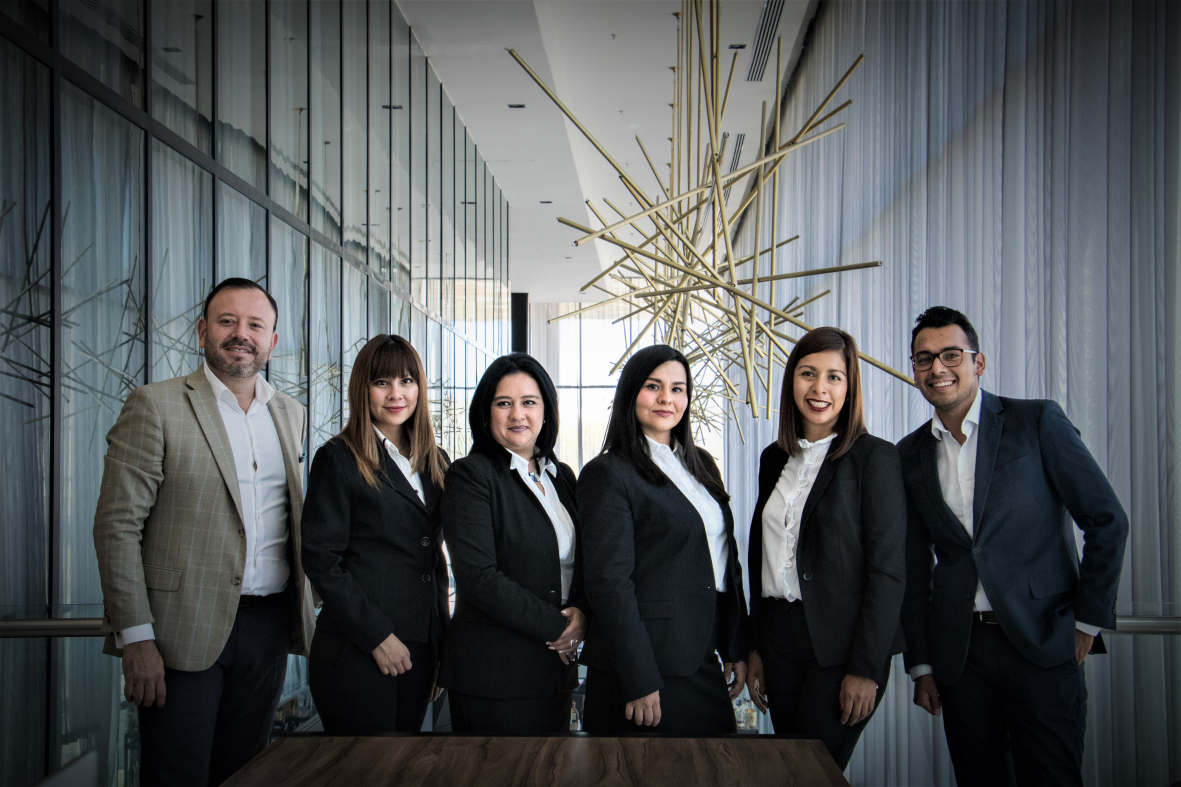

In [ ]:
cv2_imshow(resized)

The little math is used to exactly calculate the correct resizing dimension, it is important to keep the same proportion when scaling an image, otherwise some features might get lost.
Then, `cv2` exposes the resize method, where it is enought to pass the image to resize, the desired output dimension and the interpolation function.

Since we want to detect faces in an image, and then blur them out we can achieve this task by following few steps:

* Detect the face(s)
* Create a copy of the original image in order to "subtract" the face area from it
* Iterate over the detected faces and blur the face area on the copied image
* Cut out the face(s) from the original image
* Cut out the background (what is not "face") from the original image
* Merge the blurred faces with the original image

To use the cascade detector `CascadeClassifier` offers a method called `detectMultiScale` to which we need to pass: 
* the image we want to "scan" 
* the scale factor specifying how much the image size is reduced at each image scale (`scaleFactor`).
* the minimum number of neightbours specifying how many neighbors each candidate rectangle should have to retain it (`minNeighbors`).
* The minimum object size (`minSize`).

Think of it as an `sklearn` classifier, we have a trained model and we access the analogue method `detectMultiScale`, similar to `clf.predict()` 

In [ ]:
# Detect faces
faces = face_cascade.detectMultiScale(
    resized,
    scaleFactor=1.5,
    minNeighbors=5,
    minSize=(30, 30))

In [ ]:
faces

array([[208, 297,  68,  68],
       [905, 332,  68,  68],
       [787, 350,  68,  68],
       [361, 355,  68,  68],
       [631, 361,  68,  68],
       [483, 376,  68,  68]], dtype=int32)

`detectMultiScale` simply returns an array with the coordinates at which faces appears, perfect for drawing a rectagnle around it!

Now, we can initiate a copy of the original image toghter with an "empty" image which will be used as a mask to substract the "not face" from the background

In [ ]:
tempImg = resized.copy()
maskShape = (resized.shape[0], resized.shape[1], 1)
mask = np.full(maskShape, 0, dtype=np.uint8)

The next step consists in iterating over the detect faces and drawing a shape, blurring it or every other possible operation we would like to perform on detected faces:

In [ ]:
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    
    # Get the center of the face rectangle
    x_center = x + (w/2).astype(int)
    y_center = y + (h/2).astype(int)
    
    # Blur the tempImg in the area [y:y+h, x:x+w] aka where the face is.
    tempImg[y:y+h, x:x+w] = cv2.blur(tempImg[y:y+h, x:x+w] ,(50, 50))
    
    # Draw a circle in the mask image 
    # corresponsing to where the faces are in the original image
    
    cv2.circle(tempImg ,(x_center, y_center), int(h / 2), (255, 0, 0))
    cv2.circle(mask , (int((x + x + w )/2), int((y + y + h)/2 )), int(h / 2), (255, 0, 0), -1)


At this point another mask, corresponding to the bitwise operatore not is created from the original mask containing the circle draw in the for loop, representing a circle around each face detected.

The `background_img` is created by taking the original image and applying the inverted mask, hence removing the faces from it.
The second image, the foreground, is created in exactly the same way, but using the inverted mask.

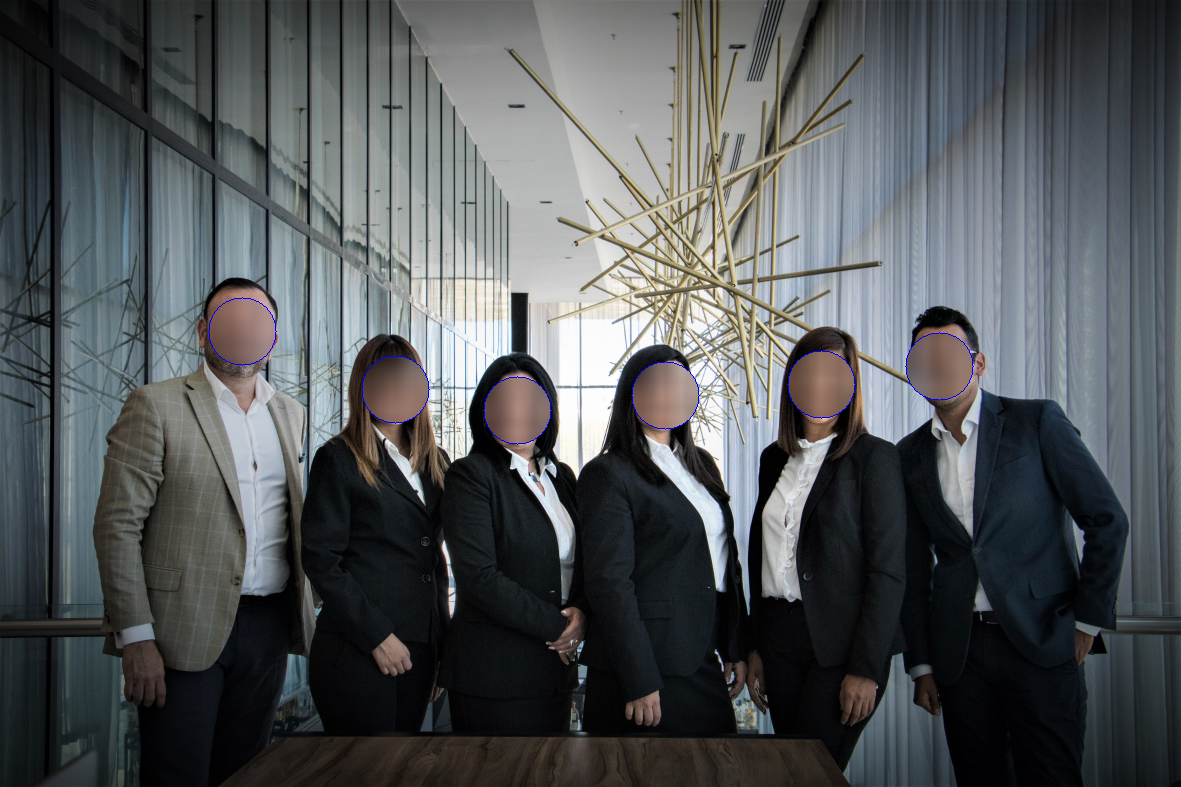

In [ ]:
mask_inv = cv2.bitwise_not(mask)
background_img = cv2.bitwise_and(resized, resized, mask = mask_inv)
foreground_img = cv2.bitwise_and(tempImg, tempImg, mask = mask)
dst = cv2.add(background_img, foreground_img)

# Display the output
cv2_imshow(dst)

In [ ]:
# Saving the images

cv2.imwrite('./foreground.jpg', foreground_img)
cv2.imwrite('./background_img.jpg', background_img)
cv2.imwrite('./final_img.jpg', dst)

True